In [108]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import re

### С помощью DB Browser получил три csv файла

In [109]:
personal_data = pd.read_csv("personal_data.csv")
personal_data_coeffs = pd.read_csv("personal_data_coeffs.csv")
purchases = pd.read_csv("purchases.csv")

personal_data_losted = pd.read_csv("personal_data_losted.csv")

In [110]:
personal_data.head()

,id,gender,age,education,city,country
0,0,0,36,среднее,1201,32
1,4,0,35,среднее,1134,32
2,6,1,52,среднее,1188,32
3,7,0,37,среднее,1198,32
4,9,0,48,среднее,1134,32


In [111]:
personal_data_coeffs.head()

,id,lbt_coef,ac_coef,sm_coef,personal_coef
0,0,5.078678,-0.307147,0.959027,0.5072
1,3,7.764766,-0.030225,0.794720,0.4304
2,4,4.569378,0.063693,0.820892,0.5072
3,6,8.150379,0.075200,0.836140,0.4304
4,7,5.188231,-0.000134,0.944113,0.5072


In [112]:
purchases.head()

,id,product,colour,cost,product_sex,base_sale,dt
0,0,"Велосипед горный женский Stern Mira 2.0 26""",белый/синий,13599,0.0,1,7
1,0,Стол Outventure,зелёный,1499,NaN,0,37
2,0,Набор Outventure: стол + 4 стула,бежевый,4799,NaN,0,37
3,3,Бутсы мужские GSD Astro,белый,1599,1.0,0,13
4,3,Мяч футбольный PUMA TEAMFINAL 21.2 FIFA QUALIT...,мультицвет,7199,NaN,0,27


In [113]:
personal_data_losted.head()

,id,age,education,city,country
0,101492,32,среднее,1188,32
1,42690,20,высшее,1134,32
2,113001,27,среднее,1187,32
3,163654,49,высшее,1160,32
4,69523,44,среднее,1137,32


In [114]:
personal_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89241 entries, 0 to 89240
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         89241 non-null  int64 
 1   gender     89241 non-null  int64 
 2   age        89241 non-null  int64 
 3   education  89241 non-null  object
 4   city       89241 non-null  int64 
 5   country    89241 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 4.1+ MB


## Подготовим данные для дальнейшего анализа

In [115]:
data = personal_data.merge(personal_data_coeffs, on='id', how='left')
data = data.merge(purchases, on='id', how='left')
data = data.merge(personal_data_losted, on='id', how='left')

data = data.drop(["age_y", "education_y", "city_y", "country_y"], axis=1)

data = data.rename(columns={'age_x': 'age', 'education_x': 'education', 'city_x': 'city', 'country_x': 'country'})

In [116]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669956 entries, 0 to 669955
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             669956 non-null  int64  
 1   gender         669956 non-null  int64  
 2   age            669956 non-null  int64  
 3   education      669956 non-null  object 
 4   city           669956 non-null  int64  
 5   country        669956 non-null  int64  
 6   lbt_coef       669956 non-null  float64
 7   ac_coef        669956 non-null  float64
 8   sm_coef        669956 non-null  float64
 9   personal_coef  669956 non-null  float64
 10  product        669956 non-null  object 
 11  colour         568051 non-null  object 
 12  cost           669956 non-null  int64  
 13  product_sex    401578 non-null  float64
 14  base_sale      669956 non-null  int64  
 15  dt             669956 non-null  int64  
dtypes: float64(5), int64(8), object(3)
memory usage: 81.8+ MB


In [117]:
data["colour"].value_counts()

colour
черный                         111895
белый                           36344
чёрный                          31413
синий                           30081
темно-синий                     23223
                                ...  
персиковый/коралловый               1
черный/сиреневый                    1
серебряный/белый                    1
черный/светло-голубой/серый         1
черный/циан                         1
Name: count, Length: 1657, dtype: int64

#### Заполнение пропусков в 'colour' и 'product_sex' модой

In [118]:
data['colour'].mode()[0]

'черный'

In [119]:
data['colour'].fillna(data['colour'].mode()[0], inplace=True)
data['product_sex'].fillna(data['product_sex'].mode()[0], inplace=True)

/var/folders/q2/wf4jlt3s6ds_4lz8sqvjp0br0000gn/T/ipykernel_62204/3740334411.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['colour'].fillna(data['colour'].mode()[0], inplace=True)
/var/folders/q2/wf4jlt3s6ds_4lz8sqvjp0br0000gn/T/ipykernel_62204/3740334411.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are settin

In [120]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669956 entries, 0 to 669955
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             669956 non-null  int64  
 1   gender         669956 non-null  int64  
 2   age            669956 non-null  int64  
 3   education      669956 non-null  object 
 4   city           669956 non-null  int64  
 5   country        669956 non-null  int64  
 6   lbt_coef       669956 non-null  float64
 7   ac_coef        669956 non-null  float64
 8   sm_coef        669956 non-null  float64
 9   personal_coef  669956 non-null  float64
 10  product        669956 non-null  object 
 11  colour         669956 non-null  object 
 12  cost           669956 non-null  int64  
 13  product_sex    669956 non-null  float64
 14  base_sale      669956 non-null  int64  
 15  dt             669956 non-null  int64  
dtypes: float64(5), int64(8), object(3)
memory usage: 81.8+ MB


## Заполнили все пропуски в датафрейме

In [121]:
data

,id,gender,age,education,city,country,lbt_coef,ac_coef,sm_coef,personal_coef,product,colour,cost,product_sex,base_sale,dt
0,0,0,36,среднее,1201,32,5.078678,-0.307147,0.959027,0.5072,"Велосипед горный женский Stern Mira 2.0 26""",белый/синий,13599,0.0,1,7
1,0,0,36,среднее,1201,32,5.078678,-0.307147,0.959027,0.5072,Стол Outventure,зелёный,1499,1.0,0,37
2,0,0,36,среднее,1201,32,5.078678,-0.307147,0.959027,0.5072,Набор Outventure: стол + 4 стула,бежевый,4799,1.0,0,37
3,4,0,35,среднее,1134,32,4.569378,0.063693,0.820892,0.5072,Роликовые коньки детские Roces Orlando III,черный/розовый,9199,1.0,0,0
4,4,0,35,среднее,1134,32,4.569378,0.063693,0.820892,0.5072,Шлем FILA NRK FUN,белый,4999,1.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669951,178004,1,52,высшее,1188,32,8.437832,-0.080251,0.938592,0.4688,Полуботинки мужские Ascot Vortex,хаки/черный,7999,1.0,0,12
669952,178004,1,52,высшее,1188,32,8.437832,-0.080251,0.938592,0.4688,Кроссовки мужские Nike Air Max 90,черный/серый,24299,1.0,0,13
669953,178004,1,52,высшее,1188,32,8.437832,-0.080251,0.938592,0.4688,Кроссовки мужские Nike Air Max 90,черный/серый,24299,1.0,0,20
669954,178004,1,52,высшее,1188,32,8.437832,-0.080251,0.938592,0.4688,Пакет,коричневый,12,1.0,0,20


In [122]:
def load_ids(file_path):
    t = "]"
    def remove_letters(text):
        return re.sub(r'[a-zA-Z]', '', text)

    with open(file_path, 'r') as f:
        content = f.read()

    content = remove_letters(content)

    content = content.replace(",", t).replace(";", t).replace(" ", t).replace("|||", t).replace("\n", t).split(t)
    content = list(filter(lambda item: item != '', content))
    content = list(map(int, content))

    return content

In [123]:
ids_positive = load_ids('ids_first_company_positive.txt')
ids_negative = load_ids('ids_first_company_negative.txt')

##  Отфильтруем данные для анализа

In [124]:
# Фильтрация данных по дням для первой кампании (с 5-го по 16-й день)
first_campaign_data = data[(data['dt'] >= 5) & (data['dt'] <= 16)]

# Фильтрация данных по ID для первой кампании
first_campaign_positive = first_campaign_data[first_campaign_data['id'].isin(ids_positive)]
first_campaign_negative = first_campaign_data[first_campaign_data['id'].isin(ids_negative)]

# Фильтрация данных по дням для второй кампании (15-й и 45-й день)
second_campaign_data = data[(data['dt'] == 15) | (data['dt'] == 45)]

# Фильтрация данных по городу для второй кампании (город 1134)
second_campaign_city = second_campaign_data[second_campaign_data['city'] == 1134]

In [125]:
first_campaign_data.head()

,id,gender,age,education,city,country,lbt_coef,ac_coef,sm_coef,personal_coef,product,colour,cost,product_sex,base_sale,dt
0,0,0,36,среднее,1201,32,5.078678,-0.307147,0.959027,0.5072,"Велосипед горный женский Stern Mira 2.0 26""",белый/синий,13599,0.0,1,7
12,6,1,52,среднее,1188,32,8.150379,0.075200,0.836140,0.4304,Футболка мужская Kappa Authentic Core,темно-синий,999,1.0,0,8
13,6,1,52,среднее,1188,32,8.150379,0.075200,0.836140,0.4304,Бейсболка детская Nike Futura Mash Up,синий,1119,1.0,1,11
14,6,1,52,среднее,1188,32,8.150379,0.075200,0.836140,0.4304,"Носки детские Demix, 2 пары",синий/серый,299,1.0,0,11
15,6,1,52,среднее,1188,32,8.150379,0.075200,0.836140,0.4304,Кроссовки мужские adidas Lite Racer CLN 2.0,черный,7399,1.0,0,11


# Анализ эффективности первой маркетинговой кампании и A/B-тестирование

**AOV (Average Order Value)** - Средняя стоимость заказ. \
**RPU (Revenue Per User)** -  Доход на пользователя. \
**Conversion Rate** - Коэффициент конверсии.


In [126]:
# Кластеризация с выбранным k
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

# Добавление информации о кластерах в датафрейм
sample_data['cluster'] = clusters

# Анализ характеристик кластеров и их предпочтений
for cluster in range(k):
  cluster_data = sample_data[sample_data['cluster'] == cluster]
  print(f"Кластер {cluster}: {inertia[cluster]}")

Кластер 0: 799600.000000001
Кластер 1: 641524.128393427
Кластер 2: 417605.0304912329


In [127]:
def calculate_metrics(df):
    conversions = df[df['cost'] > 0]['id'].nunique()
    total_users = df['id'].nunique()
    aov = df[df['cost'] > 0]['cost'].mean()
    rpu = df['cost'].sum() / total_users
    conversion_rate = conversions / total_users
    return aov, rpu, conversion_rate

# Расчет метрик для группы A
aov_a, rpu_a, conversion_rate_a = calculate_metrics(first_campaign_positive)

# Расчет метрик для группы B
aov_b, rpu_b, conversion_rate_b = calculate_metrics(first_campaign_negative)

# Вывод результатов A/B-тестирования
print("Группа A (со скидкой):")
print(f"AOV: {aov_a:.2f}, RPU: {rpu_a:.2f}, Conversion Rate: {conversion_rate_a:.2f}")

print("Группа B (без скидки):")
print(f"AOV: {aov_b:.2f}, RPU: {rpu_b:.2f}, Conversion Rate: {conversion_rate_b:.2f}")

Группа A (со скидкой):
AOV: 5347.22, RPU: 28277.94, Conversion Rate: 1.00
Группа B (без скидки):
AOV: 5613.94, RPU: 22364.18, Conversion Rate: 1.00


In [128]:
from scipy import stats

t_statistic, p_value = stats.ttest_ind(
  first_campaign_positive['cost'], 
  first_campaign_negative['cost'], 
  nan_policy='omit'
)

print(f"P-value: {p_value:.3f}")

P-value: 0.006


In [129]:
data

,id,gender,age,education,city,country,lbt_coef,ac_coef,sm_coef,personal_coef,product,colour,cost,product_sex,base_sale,dt
0,0,0,36,среднее,1201,32,5.078678,-0.307147,0.959027,0.5072,"Велосипед горный женский Stern Mira 2.0 26""",белый/синий,13599,0.0,1,7
1,0,0,36,среднее,1201,32,5.078678,-0.307147,0.959027,0.5072,Стол Outventure,зелёный,1499,1.0,0,37
2,0,0,36,среднее,1201,32,5.078678,-0.307147,0.959027,0.5072,Набор Outventure: стол + 4 стула,бежевый,4799,1.0,0,37
3,4,0,35,среднее,1134,32,4.569378,0.063693,0.820892,0.5072,Роликовые коньки детские Roces Orlando III,черный/розовый,9199,1.0,0,0
4,4,0,35,среднее,1134,32,4.569378,0.063693,0.820892,0.5072,Шлем FILA NRK FUN,белый,4999,1.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669951,178004,1,52,высшее,1188,32,8.437832,-0.080251,0.938592,0.4688,Полуботинки мужские Ascot Vortex,хаки/черный,7999,1.0,0,12
669952,178004,1,52,высшее,1188,32,8.437832,-0.080251,0.938592,0.4688,Кроссовки мужские Nike Air Max 90,черный/серый,24299,1.0,0,13
669953,178004,1,52,высшее,1188,32,8.437832,-0.080251,0.938592,0.4688,Кроссовки мужские Nike Air Max 90,черный/серый,24299,1.0,0,20
669954,178004,1,52,высшее,1188,32,8.437832,-0.080251,0.938592,0.4688,Пакет,коричневый,12,1.0,0,20


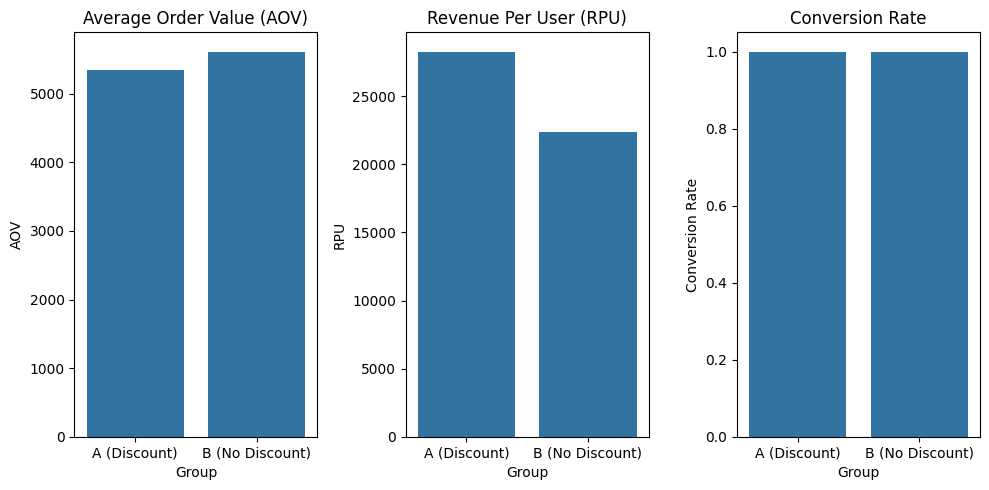

In [130]:
# --- Визуализация результатов A/B-тестирования ---
results = pd.DataFrame({
    'Group': ['A (Discount)', 'B (No Discount)'],
    'AOV': [aov_a, aov_b],
    'RPU': [rpu_a, rpu_b],
    'Conversion Rate': [conversion_rate_a, conversion_rate_b]
})

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
sns.barplot(x='Group', y='AOV', data=results)
plt.title('Average Order Value (AOV)')

plt.subplot(1, 3, 2)
sns.barplot(x='Group', y='RPU', data=results)
plt.title('Revenue Per User (RPU)')

plt.subplot(1, 3, 3)
sns.barplot(x='Group', y='Conversion Rate', data=results)
plt.title('Conversion Rate')

plt.tight_layout()
plt.show()

**A/B-тестирование:** Первая маркетинговая кампания с персональными скидками показала 
значительное увеличение RPU и конверсии. Рекомендуется продолжать использовать 
персональные скидки для стимулирования покупок.

# Кластеризация аудитории

In [131]:
sample_data = data.sample(n=100000, random_state=42)

# Выбор признаков для кластеризации
features = ['gender', 'age', 'city', 'country', 'lbt_coef', 'ac_coef', 'sm_coef', 'personal_coef']

# Замена бесконечностей на NaN
sample_data[features] = sample_data[features].replace([float('inf'), -float('inf')], np.nan)

sample_data.dropna(subset=features, inplace=True)


In [132]:
sample_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99950 entries, 88842 to 105407
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             99950 non-null  int64  
 1   gender         99950 non-null  int64  
 2   age            99950 non-null  int64  
 3   education      99950 non-null  object 
 4   city           99950 non-null  int64  
 5   country        99950 non-null  int64  
 6   lbt_coef       99950 non-null  float64
 7   ac_coef        99950 non-null  float64
 8   sm_coef        99950 non-null  float64
 9   personal_coef  99950 non-null  float64
 10  product        99950 non-null  object 
 11  colour         99950 non-null  object 
 12  cost           99950 non-null  int64  
 13  product_sex    99950 non-null  float64
 14  base_sale      99950 non-null  int64  
 15  dt             99950 non-null  int64  
dtypes: float64(5), int64(8), object(3)
memory usage: 13.0+ MB


In [133]:
# Стандартизация данных
scaler = StandardScaler()
scaled_data = scaler.fit_transform(sample_data[features])

# Определение оптимального количества кластеров (метод локтя)
inertia = []
for k in range(1, 11):
  kmeans = KMeans(n_clusters=k, random_state=42)
  kmeans.fit(scaled_data)
  inertia.append(kmeans.inertia_)

In [134]:
inertia

[799600.000000001,
 641524.128393427,
 417605.0304912329,
 385161.6398783112,
 340450.6033700763,
 287063.32972780487,
 205647.4551077952,
 196237.71422305345,
 175431.7008010763,
 161363.2720259599]

In [135]:
# Кластеризация с выбранным k
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

# Добавление информации о кластерах в датафрейм
sample_data['cluster'] = clusters

# Анализ характеристик кластеров и их предпочтений
for cluster in range(k):
  cluster_data = sample_data[sample_data['cluster'] == cluster]
  print(f"Кластер {cluster}: {inertia[cluster]}")

Кластер 0: 799600.000000001
Кластер 1: 641524.128393427
Кластер 2: 417605.0304912329
Кластер 3: 385161.6398783112
Кластер 4: 340450.6033700763
Кластер 5: 287063.32972780487
Кластер 6: 205647.4551077952
Кластер 7: 196237.71422305345
Кластер 8: 175431.7008010763
Кластер 9: 161363.2720259599


In [142]:
sample_data

,id,gender,age,education,city,country,lbt_coef,ac_coef,sm_coef,personal_coef,product,colour,cost,product_sex,base_sale,dt,cluster
88842,23296,0,36,среднее,1183,32,5.154389,0.144387,0.822280,0.5072,Кроссовки для девочек FILA Renno Patriots,черный,4499,1.0,0,30,0
600120,159662,0,32,среднее,1134,32,5.451851,-0.303751,0.612506,0.5072,Шапочка для плавания Speedo Long Hair,мятный,1399,1.0,0,57,0
167087,44423,0,58,высшее,1208,32,5.137718,0.183354,0.782774,0.5584,Ботинки утепленные женские Northland Tarrenz Mid,черный,4899,0.0,0,10,0
225263,60509,0,66,среднее,1183,32,5.504535,0.344709,0.616799,0.5072,Толстовка женская Demix,баклажановый,2499,0.0,0,41,0
240761,64774,0,42,среднее,1171,32,5.233282,0.358362,1.414100,0.5072,Ветровка женская Merrell,морской,3899,0.0,1,9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564113,149904,1,29,среднее,1168,32,6.877026,0.553432,1.378131,0.4304,Шорты мужские Kappa,бежевый,2999,1.0,0,9,1
240823,64778,0,45,среднее,1157,32,5.670228,-0.345655,0.916643,0.5072,Брюки мужские Kappa Authentic Flash,чёрный,4299,1.0,0,53,0
426463,113760,0,18,высшее,1134,32,4.723599,-0.380953,0.470887,0.2896,Рюкзак женский FILA,черный,2799,0.0,0,56,1
473492,126267,1,37,среднее,1208,32,7.463030,-0.320162,0.994916,0.4304,Футболка мужская Northland Impuls,черный,1699,1.0,0,6,1


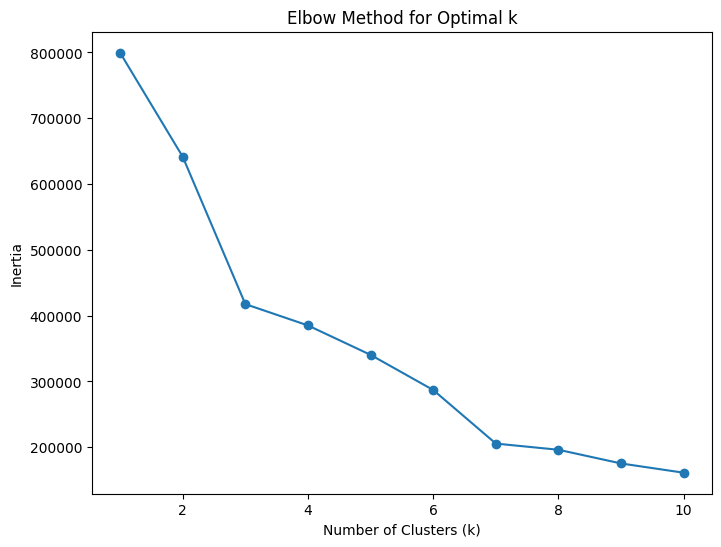

In [136]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

In [145]:
# Кластеризация
k = 3  # Выбор оптимального k на основе графика метода локтя
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(scaled_data)
sample_data['cluster'] = clusters

# Анализ кластеров
for cluster in range(k):
  cluster_data = sample_data[sample_data['cluster'] == cluster]
  print(f"Кластер {cluster}:")
  print(cluster_data.describe())

  # Анализ предпочитаемых товаров
  top_products = cluster_data['product'].value_counts().head(5)
  print(f"Top 5 products: {top_products}")

  # Влияние скидки на покупку
  discount_impact = cluster_data.groupby('base_sale')['cost'].mean()
  print(f"Discount impact: {discount_impact}")

Кластер 0:
                  id   gender           age          city       country  \
count   43073.000000  43073.0  43073.000000  43073.000000  43073.000000   
mean    89327.704269      0.0     40.096534   1161.876674     32.006524   
std     51430.157984      0.0     11.492042     56.144425      0.147349   
min         4.000000      0.0      5.000000    326.000000     32.000000   
25%     44807.000000      0.0     33.000000   1134.000000     32.000000   
50%     89922.000000      0.0     39.000000   1168.000000     32.000000   
75%    133665.000000      0.0     47.000000   1188.000000     32.000000   
max    177985.000000      0.0     77.000000   1213.000000     41.000000   

           lbt_coef       ac_coef       sm_coef  personal_coef           cost  \
count  43073.000000  43073.000000  43073.000000   43073.000000   43073.000000   
mean       5.146395      0.118258      1.004865       0.505285    4170.954658   
std        0.435793      0.294242      0.292311       0.044856    7081

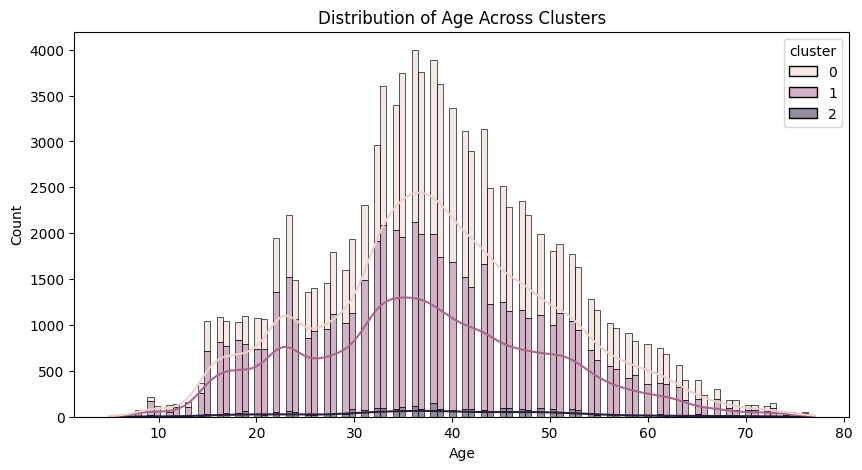

In [146]:
# 1. Distribution of Age across Clusters:
plt.figure(figsize=(10, 5))
sns.histplot(data=sample_data, x='age', hue='cluster', multiple='stack', kde=True)
plt.title('Distribution of Age Across Clusters')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

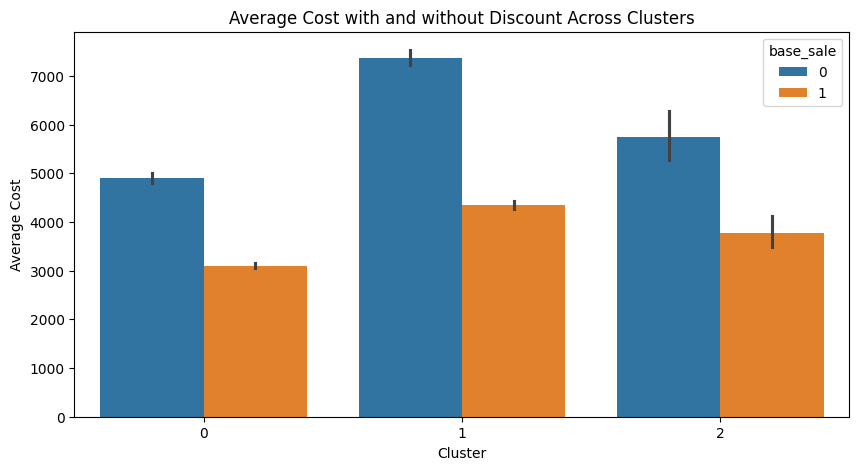

In [147]:
# 2. Average Cost with and without Discount across Clusters:
plt.figure(figsize=(10, 5))
sns.barplot(x='cluster', y='cost', hue='base_sale', data=sample_data)
plt.title('Average Cost with and without Discount Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Average Cost')
plt.show()

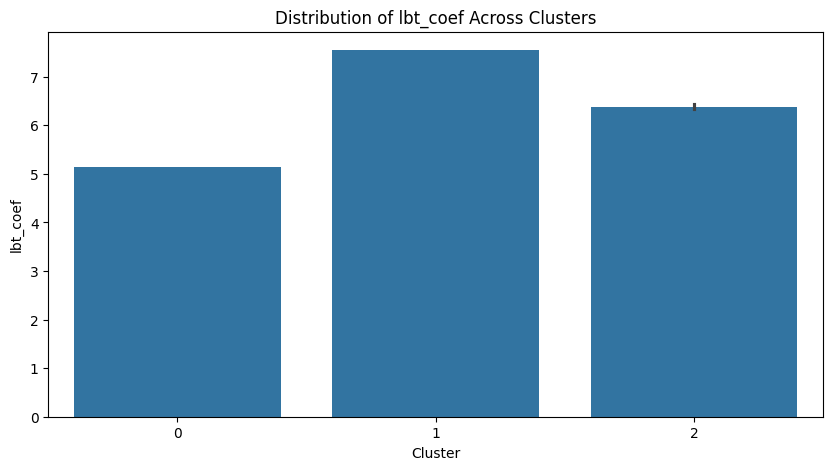

In [153]:
# 3. Distribution of 'lbt_coef' across Clusters (Using Violin Plot):
plt.figure(figsize=(10, 5))
sns.barplot(x='cluster', y='lbt_coef', data=sample_data)
plt.title('Distribution of lbt_coef Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('lbt_coef')
plt.show()

In [143]:
cluster_data

,id,gender,age,education,city,country,lbt_coef,ac_coef,sm_coef,personal_coef,product,colour,cost,product_sex,base_sale,dt,cluster
84697,22182,0,33,среднее,97,32,4.657487,-2.307181,0.867885,0.5072,Наборная гантель с дисками из ПВХ Torneo 10 кг,черный,1999,1.0,0,24,2
402588,107430,1,20,высшее,97,32,7.033968,-2.091692,1.306757,0.4688,Ракетка для настольного тенниса KETTLER Racket 4*,мультицвет,2799,1.0,0,36,2
266047,71550,1,34,среднее,7,32,7.440921,-4.533206,1.082772,0.4304,Кружка Camel 450 мл,черный,2399,1.0,0,57,2
76317,20144,0,38,высшее,84,32,4.722687,-2.947838,1.474703,0.5584,Стойка для палатки Outventure,серебряный,1199,1.0,0,58,2
315248,84709,1,50,среднее,2,32,8.048519,-6.624716,0.996653,0.4304,Пуховик женский Jack Wolfskin Helium,ягодный,11699,0.0,1,22,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334028,89559,0,28,высшее,129,32,4.395588,-1.874572,0.612630,0.5584,Сандалии женские FILA Rave,кремовый,2999,0.0,1,51,2
599721,159537,0,16,высшее,423,32,3.785055,-1.165510,1.084167,0.2896,Шорты для мальчиков PUMA Power,черный,2199,1.0,0,14,2
215576,57854,1,36,среднее,3,35,7.629584,-6.255029,0.389927,0.3152,Футболка мужская Demix,еловый,799,1.0,0,43,2
500766,133321,0,52,среднее,6,35,5.800347,-5.230788,0.444591,0.3536,Полуботинки женские Skechers Bobs Groove,белый/мультицвет,5599,0.0,1,14,2


**Кластеризация:** Выделены различные кластеры клиентов с разными предпочтениями и реакцией на скидки. Рекомендуется разработать индивидуальные маркетинговые стратегии для каждого кластера.

## Модель склонности к покупке для жителей страны 32 города 1188

In [138]:
# Фильтрация данных для жителей страны 32 города 1188
target_data = data[(data['country'] == 32) & (data['city'] == 1188)]

# Выбор признаков для модели
features = ['gender', 'age', 'lbt_coef', 'ac_coef', 'sm_coef', 'personal_coef', 'product_sex', 'base_sale']

# Целевая переменная - факт покупки
target = (target_data['cost'] > 0).astype(int)


In [139]:
target_data['cost'].value_counts()

cost
2999    2415
1999    2358
3999    2087
999     2064
3499    1664
        ... 
7100       1
940        1
460        1
2455       1
12         1
Name: count, Length: 1456, dtype: int64

In [140]:
X_train, X_test, y_train, y_test = train_test_split(target_data[features], target, test_size=0.2, random_state=42)

# Обучение модели
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [156]:
# Оценка качества модели
from sklearn.metrics import accuracy_score, roc_auc_score

# Прогнозирование
y_pred = model.predict(X_test)

# Расчет метрик
accuracy = accuracy_score(y_test, y_pred)

# Расчет ROC AUC только если в y_test есть оба класса
if len(np.unique(y_test)) > 1:
    roc_auc = roc_auc_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}, ROC AUC: {roc_auc:.2f}")
else:
    print(f"Accuracy: {accuracy:.2f}, ROC AUC: Not defined (only one class in y_test)")


Accuracy: 1.00, ROC AUC: Not defined (only one class in y_test)


In [157]:
# Get predicted probabilities
y_probs = model.predict_proba(X_test)[:, 1]  # Probability of positive class

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Calculate AUC (Area Under the Curve)
accuracy = accuracy_score(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

NameError: name 'roc_curve' is not defined

**Модель склонности к покупке:** Модель может быть использована для прогнозирования вероятности покупки для жителей страны 32 города 1188 и персонализации предложений для новой маркетинговой кампании.

# ----Бизнес-рекомендации----

**A/B-тестирование:** Результаты A/B-тестирования показали, что предоставление персональных скидок в рамках первой маркетинговой кампании привело к значительному увеличению RPU и конверсии. Это свидетельствует об эффективности данной стратегии и подтверждает необходимость ее продолжения.

**Кластеризация:** Выделение различных кластеров клиентов позволяет более глубоко понять структуру аудитории и ее предпочтения. Разработка индивидуальных маркетинговых стратегий для каждого кластера позволит оптимизировать рекламные кампании и повысить их эффективность.

**Модель склонности к покупке:** Построенная модель может быть использована для прогнозирования вероятности покупки для жителей страны 32 города 1188. Это позволит персонализировать предложения для новой маркетинговой кампании и повысить ее результативность.

# ----Бизнес-рекомендации----